In [94]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy

In [81]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)

### removing two outliers in ROUND data:

In [82]:
outliers_ROUND = ['RefCurve_2020-03-16_61_135841.Wfm.bin', 'RefCurve_2020-03-16_86_141506.Wfm.bin']
res_df_ROUND = res_df_ROUND[~res_df_ROUND['waveform_file'].isin(outliers_ROUND)]

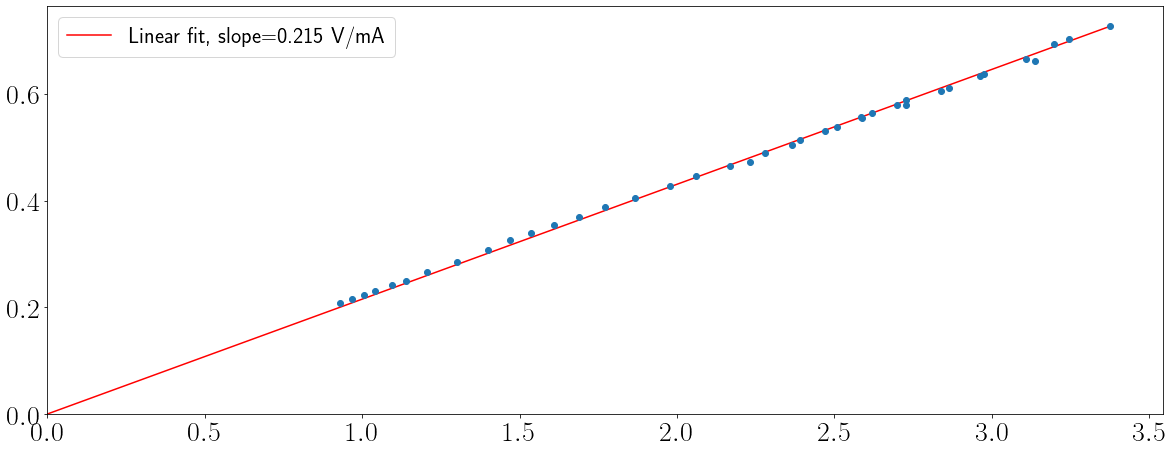

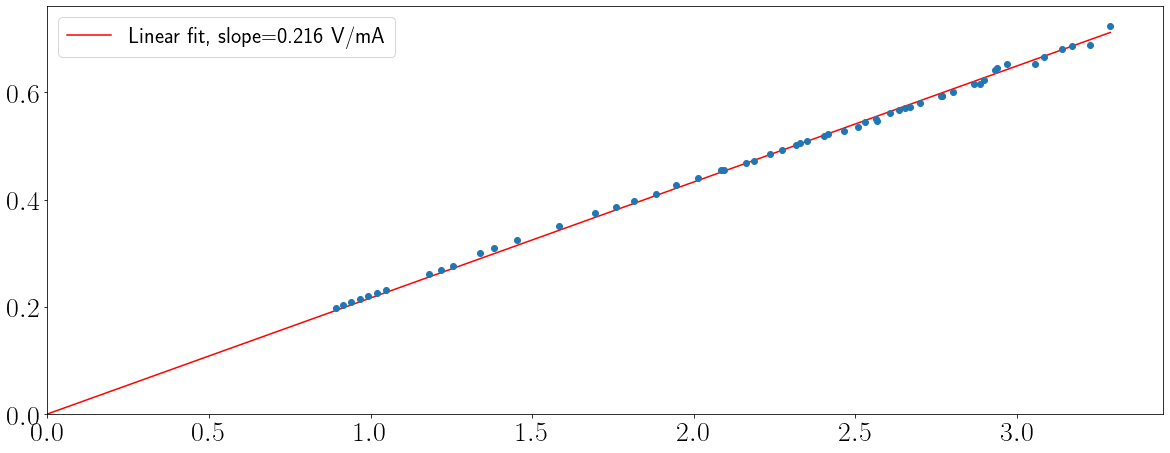

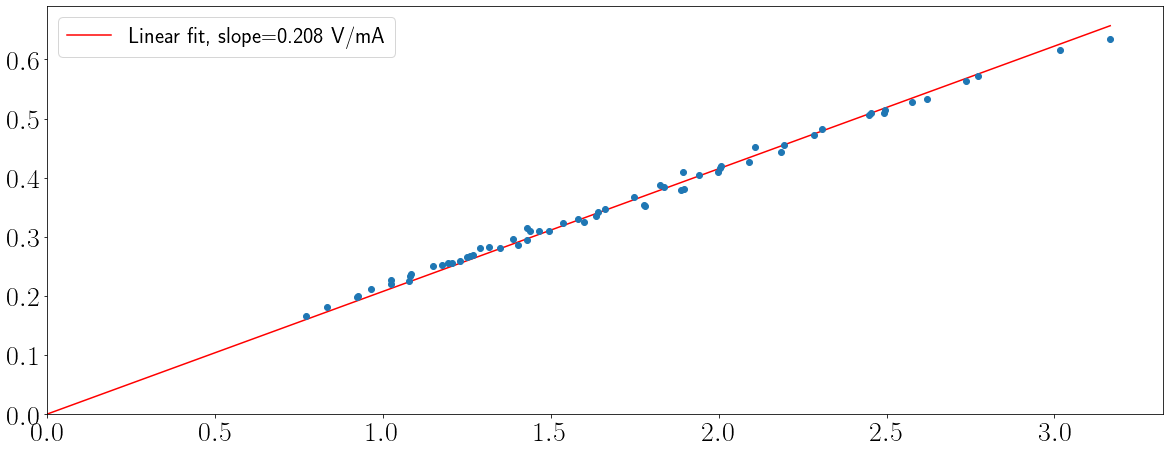

In [92]:
data_sets = {
    'FLAT': res_df_FLAT,
    'ROUND': res_df_ROUND,
    'ROUNDLONG': res_df_ROUND_Low_RF}
current_to_sum_channel = {}
for name, df in data_sets.items():
    fig, ax = plt.subplots()
    df_no_outliers = df[df["ch2_amplitude"] > 0.05]
    x = -df_no_outliers['N:IWCMI_recalibrated_to_IWCMI_absolute'].values
    y = df_no_outliers["ch2_amplitude"].values
    reg = linear_model.LinearRegression(fit_intercept=False)
    reg.fit(x.reshape((len(x), 1)), y)
    a = reg.coef_[0]
    current_to_sum_channel[name] = a
    ax.plot([0, max(x)],[0, a*max(x)], color='red',
    label="Linear fit, slope={:.3f} V/mA".format(a))
    ax.plot(x, y,'o')
    ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.legend()
    plt.show()

In [95]:
cur_to_sum_channel = 0.5*(current_to_sum_channel['FLAT']+current_to_sum_channel['ROUND'])
save_to_config("Beam_current_to_Sum_channel_ampl_V/mA", cur_to_sum_channel)

In [96]:
sum_channel_to_photoelectrons = 1/get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")*1e-3*get_from_config("IOTA_revolution_period")/get_from_config("e")*get_from_config("Measured_photons_per_electron")
save_to_config('sum_channel_to_photoelectrons', sum_channel_to_photoelectrons)